In [1]:
import os
import ast
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["font.sans-serif"]=["WenQuanYi Micro Hei"] #设置字体
plt.rcParams["axes.unicode_minus"]=False #该语句解决图像中的“-”负号的乱码问题

# 禁止随机，结果可复现
random.seed(42)
np.random.seed(42)

## 超参数选择

In [2]:
# Parameters
emo_index_id = 0
stage_id = 0
model_id = 0
data_number = 20

In [3]:
# Parameters
emo_index_id = 0
stage_id = 0
model_id = 5
data_number = 200


In [4]:
emo_index = ['上证综合情绪值', '沪深300情绪值', '创业板情绪值'][emo_index_id]
stage = ['计算矩阵', '读取矩阵'][stage_id]
model = ['Emo-Dict/DLUT', 'Emo-Dict/Bian', 'Emo-Dict/Jiang',
         'Machine-learning/LR', 'Machine-learning/RF', 'Machine-learning/SVM', 
         'Deep-learning/Separated_task'][model_id]

ROOT_PATH = '/data/public/fintechlab/zdh/Individual-Stock-Analysis/B_Temporal_Clustering'
Clustering_Method = 'Clustering_Based_on_Separation'
Emotion_Data_PATH = f'{ROOT_PATH}/data/Emotion_Data/{model}'   # 情绪数据路径
Financial_Data_PATH = f'{ROOT_PATH}/data/Financial_Data' # 金融数据路径

print(f"Running with: emo_index={emo_index}, stage={stage}, model={model}, data_number={data_number}")

Running with: emo_index=上证综合情绪值, stage=计算矩阵, model=Machine-learning/SVM, data_number=200


## 数据准备

In [5]:
"""读取股吧个股的数据"""
all_data = []
file_list = [f for f in os.listdir(Emotion_Data_PATH) if f.endswith('.csv')]

for file in file_list:
    file_path = os.path.join(Emotion_Data_PATH, file)
    df = pd.read_csv(file_path)
    stock_code = os.path.splitext(file)[0] # 获取股票编号（文件名去掉扩展名）
    
    # 提取每一行的日期和情绪值
    for _, row in df.iterrows():
        new_row = {
            '股票编号': stock_code,
            '日期': row['日期'],
            '上证综合情绪值': row['上证综合情绪值'],
            '沪深300情绪值': row['沪深300情绪值'],
            '创业板情绪值': row['创业板情绪值']
        }
        all_data.append(new_row)
        
guba_data = pd.DataFrame(all_data)
guba_data

,股票编号,日期,上证综合情绪值,沪深300情绪值,创业板情绪值
0,601933,2024-12-27,0.048365,0.028544,-0.006138
1,601933,2024-11-18,-0.242671,-0.338993,-0.460030
2,601933,2024-11-17,-0.031017,-0.009014,-0.180763
3,601933,2024-11-17,-0.167612,-0.170838,-0.367941
4,601933,2024-11-17,-0.167612,-0.170838,-0.367941
...,...,...,...,...,...
495326,601919,2021-04-09,-0.167612,-0.170838,-0.367941
495327,601919,2021-04-09,-0.167612,-0.170838,-0.367941
495328,601919,2021-04-08,-0.107420,-0.136616,-0.261801
495329,601919,2021-04-08,-0.054551,-0.103612,-0.128968


In [6]:
"""读取股票回报率的数据"""
return_data = pd.read_csv(f'{Financial_Data_PATH}/日个股回报率.csv', dtype={'股票编号': str})
return_data

,股票编号,日期,交易量,收益率变化
0,000002,2021-06-01,60990961,-0.003745
1,000002,2021-06-02,85354506,0.006015
2,000002,2021-06-03,50594187,-0.003363
3,000002,2021-06-04,71422364,-0.012748
4,000002,2021-06-07,64745280,-0.014812
...,...,...,...,...
154877,688981,2024-11-20,58507495,-0.017071
154878,688981,2024-11-21,56197106,0.002358
154879,688981,2024-11-22,79240108,-0.050588
154880,688981,2024-11-25,76905909,-0.029402


In [7]:
# 进行左连接，guba_data 为主表
merged_data = pd.merge(guba_data, return_data[['股票编号', '日期', '交易量', '收益率变化']], 
                       on=['股票编号', '日期'], 
                       how='left')
merged_data = merged_data.dropna()
merged_data

,股票编号,日期,上证综合情绪值,沪深300情绪值,创业板情绪值,交易量,收益率变化
1,601933,2024-11-18,-0.242671,-0.338993,-0.460030,310012824.0,-0.004608
11,601933,2024-11-15,-0.167612,-0.170838,-0.367941,423271473.0,-0.064655
12,601933,2024-11-15,-0.167612,-0.170838,-0.367941,423271473.0,-0.064655
13,601933,2024-11-14,-0.167612,-0.170838,-0.367941,372259052.0,-0.053061
14,601933,2024-11-14,-0.167612,-0.170838,-0.367941,372259052.0,-0.053061
...,...,...,...,...,...,...,...
495148,601919,2021-06-01,-0.167612,-0.170838,-0.367941,268816321.0,0.045859
495149,601919,2021-06-01,-0.120769,-0.159457,-0.308475,268816321.0,0.045859
495150,601919,2021-06-01,-0.029216,-0.077231,-0.073883,268816321.0,0.045859
495151,601919,2021-06-01,-0.309000,-0.368095,-0.376385,268816321.0,0.045859


## 数据预处理

In [8]:
# Step 1: 对情绪值列进行 Min-Max 标准化
def min_max_normalization(df, cols):
    for col in cols:
        min_val = df[col].min()
        max_val = df[col].max()
        df[col] = 2 * (df[col] - min_val) / (max_val - min_val) - 1
    return df

# Step 2: 对每个股票编号的数据进行标准化和按日期汇总
def process_data(df):
    df_processed = pd.DataFrame()  # 用于存储结果
    for stock_code, stock_data in df.groupby('股票编号'):
        # 对每个股票编号内的数据进行标准化
        stock_data = min_max_normalization(stock_data, ['上证综合情绪值', '沪深300情绪值', '创业板情绪值'])
        
        # 按日期汇总数据，同时保留股票编号
        stock_summary = stock_data.groupby('日期').agg({
            '股票编号': 'first',  # 保留股票编号（在同一日期内它是相同的，使用 'first'）
            '上证综合情绪值': 'mean',  # 上证综合情绪值按日期取均值
            '沪深300情绪值': 'mean',  # 沪深300情绪值按日期取均值
            '创业板情绪值': 'mean',  # 创业板情绪值按日期取均值
            '交易量': 'mean',  # 交易量按日期求和
            '收益率变化': 'mean'  # 收益率变化按日期取均值
        }).reset_index(drop=False)
        
        df_processed = pd.concat([df_processed, stock_summary], ignore_index=True)
    
    return df_processed

# 调用处理函数
final_data = process_data(merged_data)
final_data

,日期,股票编号,上证综合情绪值,沪深300情绪值,创业板情绪值,交易量,收益率变化
0,2021-06-01,000002,0.680410,0.627242,0.493338,60990961.0,-0.003745
1,2021-06-08,000002,0.658871,0.597697,0.448880,44676494.0,0.004626
2,2021-06-10,000002,0.686813,0.637801,0.503702,53800776.0,-0.010035
3,2021-06-11,000002,0.680410,0.627242,0.493338,75853738.0,-0.014035
4,2021-06-15,000002,0.677162,0.621400,0.473099,89915501.0,-0.020957
...,...,...,...,...,...,...,...
85724,2024-11-12,688981,0.522285,0.447128,0.459594,108866759.0,-0.036864
85725,2024-11-13,688981,0.520579,0.447234,0.461487,80759477.0,-0.019484
85726,2024-11-14,688981,0.497081,0.420732,0.431448,76194102.0,-0.022897
85727,2024-11-15,688981,0.513551,0.439638,0.450697,71066743.0,-0.020233


## DTW 聚类

In [9]:
# 选择需要的列
dtw_df = final_data[['日期', '股票编号', emo_index, '收益率变化']]

# 按照股票编号和日期排序
dtw_df = dtw_df.sort_values(by=['股票编号', '日期'])

# 创建一个以股票编号为键，日期为时间序列的字典
stock_data = {}
if data_number > len(dtw_df['股票编号'].unique()):
    data_number = len(dtw_df['股票编号'].unique())
for stock in dtw_df['股票编号'].unique()[:data_number]:
    stock_data[stock] = dtw_df[dtw_df['股票编号'] == stock][['日期', emo_index, '收益率变化']].reset_index(drop=True)

In [10]:
if stage == '计算矩阵':
    from tqdm import tqdm
    from fastdtw import fastdtw
    from scipy.spatial.distance import euclidean
    
    # 假设stock_data已经准备好了，stock_ids包含所有股票编号
    stock_ids = list(stock_data.keys())
    dtw_distances = np.zeros((len(stock_ids), len(stock_ids)))
    
    # 使用 tqdm 包装外层循环以显示进度条
    for i, stock_i in tqdm(enumerate(stock_ids), total=len(stock_ids), desc="计算 DTW 距离", unit="股票"):
        for j, stock_j in enumerate(stock_ids):
            if i < j:
                series_i = stock_data[stock_i][[emo_index, '收益率变化']].values
                series_j = stock_data[stock_j][[emo_index, '收益率变化']].values
                distance, _ = fastdtw(series_i, series_j, dist=euclidean)
                dtw_distances[i, j] = distance
                dtw_distances[j, i] = distance  # 对称距离矩阵
    
    
    if emo_index == '上证综合情绪值':
        os.makedirs(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_上证综合', exist_ok=True)
        np.save(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_上证综合/dtw_distances.npy', dtw_distances)
    if emo_index == '沪深300情绪值':
        os.makedirs(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_沪深300', exist_ok=True)
        np.save(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_沪深300/dtw_distances.npy', dtw_distances)
    if emo_index == '创业板情绪值':
        os.makedirs(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_创业板', exist_ok=True)
        np.save(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_创业板/dtw_distances.npy', dtw_distances)
    print(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_上证综合')

计算 DTW 距离:   0%|          | 0/183 [00:00<?, ?股票/s]

计算 DTW 距离:   1%|          | 1/183 [00:13<41:20, 13.63s/股票]

计算 DTW 距离:   1%|          | 2/183 [00:20<29:24,  9.75s/股票]

计算 DTW 距离:   2%|▏         | 3/183 [00:34<34:52, 11.62s/股票]

计算 DTW 距离:   2%|▏         | 4/183 [00:43<31:38, 10.61s/股票]

计算 DTW 距离:   3%|▎         | 5/183 [00:56<34:10, 11.52s/股票]

计算 DTW 距离:   3%|▎         | 6/183 [01:09<35:29, 12.03s/股票]

计算 DTW 距离:   4%|▍         | 7/183 [01:18<32:17, 11.01s/股票]

计算 DTW 距离:   4%|▍         | 8/183 [01:32<34:42, 11.90s/股票]

计算 DTW 距离:   5%|▍         | 9/183 [01:46<36:20, 12.53s/股票]

计算 DTW 距离:   5%|▌         | 10/183 [01:58<35:47, 12.41s/股票]

计算 DTW 距离:   6%|▌         | 11/183 [02:08<33:12, 11.58s/股票]

计算 DTW 距离:   7%|▋         | 12/183 [02:20<33:19, 11.69s/股票]

计算 DTW 距离:   7%|▋         | 13/183 [02:33<34:12, 12.07s/股票]

计算 DTW 距离:   8%|▊         | 14/183 [02:46<34:43, 12.33s/股票]

计算 DTW 距离:   8%|▊         | 15/183 [02:54<30:58, 11.06s/股票]

计算 DTW 距离:   9%|▊         | 16/183 [03:00<26:32,  9.54s/股票]

计算 DTW 距离:   9%|▉         | 17/183 [03:08<25:37,  9.26s/股票]

计算 DTW 距离:  10%|▉         | 18/183 [03:16<24:21,  8.86s/股票]

计算 DTW 距离:  10%|█         | 19/183 [03:25<24:28,  8.96s/股票]

计算 DTW 距离:  11%|█         | 20/183 [03:35<24:41,  9.09s/股票]

计算 DTW 距离:  11%|█▏        | 21/183 [03:46<26:20,  9.76s/股票]

计算 DTW 距离:  12%|█▏        | 22/183 [03:55<25:43,  9.58s/股票]

计算 DTW 距离:  13%|█▎        | 23/183 [04:03<24:16,  9.10s/股票]

计算 DTW 距离:  13%|█▎        | 24/183 [04:12<23:59,  9.05s/股票]

计算 DTW 距离:  14%|█▎        | 25/183 [04:24<26:10,  9.94s/股票]

计算 DTW 距离:  14%|█▍        | 26/183 [04:36<27:27, 10.50s/股票]

计算 DTW 距离:  15%|█▍        | 27/183 [04:47<27:23, 10.54s/股票]

计算 DTW 距离:  15%|█▌        | 28/183 [04:57<27:10, 10.52s/股票]

计算 DTW 距离:  16%|█▌        | 29/183 [05:05<24:50,  9.68s/股票]

计算 DTW 距离:  16%|█▋        | 30/183 [05:15<25:04,  9.83s/股票]

计算 DTW 距离:  17%|█▋        | 31/183 [05:22<23:03,  9.10s/股票]

计算 DTW 距离:  17%|█▋        | 32/183 [05:32<23:11,  9.21s/股票]

计算 DTW 距离:  18%|█▊        | 33/183 [05:43<24:14,  9.70s/股票]

计算 DTW 距离:  19%|█▊        | 34/183 [05:54<25:06, 10.11s/股票]

计算 DTW 距离:  19%|█▉        | 35/183 [06:04<24:50, 10.07s/股票]

计算 DTW 距离:  20%|█▉        | 36/183 [06:15<25:42, 10.49s/股票]

计算 DTW 距离:  20%|██        | 37/183 [06:22<22:37,  9.30s/股票]

计算 DTW 距离:  21%|██        | 38/183 [06:31<22:15,  9.21s/股票]

计算 DTW 距离:  21%|██▏       | 39/183 [06:39<21:05,  8.79s/股票]

计算 DTW 距离:  22%|██▏       | 40/183 [06:44<18:42,  7.85s/股票]

计算 DTW 距离:  22%|██▏       | 41/183 [06:53<19:32,  8.25s/股票]

计算 DTW 距离:  23%|██▎       | 42/183 [07:03<20:38,  8.79s/股票]

计算 DTW 距离:  23%|██▎       | 43/183 [07:11<19:40,  8.43s/股票]

计算 DTW 距离:  24%|██▍       | 44/183 [07:17<17:34,  7.59s/股票]

计算 DTW 距离:  25%|██▍       | 45/183 [07:27<19:32,  8.49s/股票]

计算 DTW 距离:  25%|██▌       | 46/183 [07:34<18:06,  7.93s/股票]

计算 DTW 距离:  26%|██▌       | 47/183 [07:42<18:11,  8.02s/股票]

计算 DTW 距离:  26%|██▌       | 48/183 [07:49<17:20,  7.71s/股票]

计算 DTW 距离:  27%|██▋       | 49/183 [07:56<16:26,  7.36s/股票]

计算 DTW 距离:  27%|██▋       | 50/183 [08:05<17:35,  7.94s/股票]

计算 DTW 距离:  28%|██▊       | 51/183 [08:13<17:16,  7.85s/股票]

计算 DTW 距离:  28%|██▊       | 52/183 [08:21<17:33,  8.04s/股票]

计算 DTW 距离:  29%|██▉       | 53/183 [08:25<15:03,  6.95s/股票]

计算 DTW 距离:  30%|██▉       | 54/183 [08:31<13:52,  6.45s/股票]

计算 DTW 距离:  30%|███       | 55/183 [08:35<12:25,  5.83s/股票]

计算 DTW 距离:  31%|███       | 56/183 [08:40<11:57,  5.65s/股票]

计算 DTW 距离:  31%|███       | 57/183 [08:47<12:20,  5.88s/股票]

计算 DTW 距离:  32%|███▏      | 58/183 [08:52<11:47,  5.66s/股票]

计算 DTW 距离:  32%|███▏      | 59/183 [08:57<11:26,  5.53s/股票]

计算 DTW 距离:  33%|███▎      | 60/183 [09:03<11:34,  5.65s/股票]

计算 DTW 距离:  33%|███▎      | 61/183 [09:08<11:14,  5.53s/股票]

计算 DTW 距离:  34%|███▍      | 62/183 [09:13<10:20,  5.13s/股票]

计算 DTW 距离:  34%|███▍      | 63/183 [09:17<10:02,  5.02s/股票]

计算 DTW 距离:  35%|███▍      | 64/183 [09:24<11:00,  5.55s/股票]

计算 DTW 距离:  36%|███▌      | 65/183 [09:33<12:56,  6.58s/股票]

计算 DTW 距离:  36%|███▌      | 66/183 [09:40<12:50,  6.59s/股票]

计算 DTW 距离:  37%|███▋      | 67/183 [09:46<12:44,  6.59s/股票]

计算 DTW 距离:  37%|███▋      | 68/183 [09:50<11:10,  5.83s/股票]

计算 DTW 距离:  38%|███▊      | 69/183 [09:57<11:32,  6.07s/股票]

计算 DTW 距离:  38%|███▊      | 70/183 [10:04<11:45,  6.24s/股票]

计算 DTW 距离:  39%|███▉      | 71/183 [10:09<11:22,  6.09s/股票]

计算 DTW 距离:  39%|███▉      | 72/183 [10:15<11:10,  6.04s/股票]

计算 DTW 距离:  40%|███▉      | 73/183 [10:22<11:13,  6.12s/股票]

计算 DTW 距离:  40%|████      | 74/183 [10:27<10:28,  5.77s/股票]

计算 DTW 距离:  41%|████      | 75/183 [10:33<10:34,  5.87s/股票]

计算 DTW 距离:  42%|████▏     | 76/183 [10:37<09:40,  5.43s/股票]

计算 DTW 距离:  42%|████▏     | 77/183 [10:42<09:20,  5.29s/股票]

计算 DTW 距离:  43%|████▎     | 78/183 [10:50<10:35,  6.05s/股票]

计算 DTW 距离:  43%|████▎     | 79/183 [10:54<09:41,  5.59s/股票]

计算 DTW 距离:  44%|████▎     | 80/183 [11:01<10:22,  6.04s/股票]

计算 DTW 距离:  44%|████▍     | 81/183 [11:08<10:46,  6.34s/股票]

计算 DTW 距离:  45%|████▍     | 82/183 [11:15<10:56,  6.50s/股票]

计算 DTW 距离:  45%|████▌     | 83/183 [11:22<10:56,  6.57s/股票]

计算 DTW 距离:  46%|████▌     | 84/183 [11:28<10:27,  6.34s/股票]

计算 DTW 距离:  46%|████▋     | 85/183 [11:35<10:41,  6.55s/股票]

计算 DTW 距离:  47%|████▋     | 86/183 [11:42<10:43,  6.63s/股票]

计算 DTW 距离:  48%|████▊     | 87/183 [11:46<09:27,  5.91s/股票]

计算 DTW 距离:  48%|████▊     | 88/183 [11:53<09:43,  6.14s/股票]

计算 DTW 距离:  49%|████▊     | 89/183 [11:59<09:53,  6.32s/股票]

计算 DTW 距离:  49%|████▉     | 90/183 [12:04<09:11,  5.93s/股票]

计算 DTW 距离:  50%|████▉     | 91/183 [12:07<07:43,  5.04s/股票]

计算 DTW 距离:  50%|█████     | 92/183 [12:12<07:20,  4.84s/股票]

计算 DTW 距离:  51%|█████     | 93/183 [12:18<08:01,  5.35s/股票]

计算 DTW 距离:  51%|█████▏    | 94/183 [12:24<08:01,  5.41s/股票]

计算 DTW 距离:  52%|█████▏    | 95/183 [12:28<07:27,  5.08s/股票]

计算 DTW 距离:  52%|█████▏    | 96/183 [12:32<06:58,  4.81s/股票]

计算 DTW 距离:  53%|█████▎    | 97/183 [12:36<06:25,  4.49s/股票]

计算 DTW 距离:  54%|█████▎    | 98/183 [12:42<07:06,  5.01s/股票]

计算 DTW 距离:  54%|█████▍    | 99/183 [12:45<06:06,  4.36s/股票]

计算 DTW 距离:  55%|█████▍    | 100/183 [12:48<05:30,  3.99s/股票]

计算 DTW 距离:  55%|█████▌    | 101/183 [12:53<05:34,  4.08s/股票]

计算 DTW 距离:  56%|█████▌    | 102/183 [12:58<06:08,  4.55s/股票]

计算 DTW 距离:  56%|█████▋    | 103/183 [13:04<06:43,  5.05s/股票]

计算 DTW 距离:  57%|█████▋    | 104/183 [13:10<06:45,  5.13s/股票]

计算 DTW 距离:  57%|█████▋    | 105/183 [13:13<06:00,  4.62s/股票]

计算 DTW 距离:  58%|█████▊    | 106/183 [13:18<05:51,  4.56s/股票]

计算 DTW 距离:  58%|█████▊    | 107/183 [13:21<05:26,  4.30s/股票]

计算 DTW 距离:  59%|█████▉    | 108/183 [13:24<04:49,  3.86s/股票]

计算 DTW 距离:  60%|█████▉    | 109/183 [13:28<04:55,  4.00s/股票]

计算 DTW 距离:  60%|██████    | 110/183 [13:32<04:45,  3.91s/股票]

计算 DTW 距离:  61%|██████    | 111/183 [13:35<04:16,  3.56s/股票]

计算 DTW 距离:  61%|██████    | 112/183 [13:38<04:09,  3.52s/股票]

计算 DTW 距离:  62%|██████▏   | 113/183 [13:41<03:58,  3.41s/股票]

计算 DTW 距离:  62%|██████▏   | 114/183 [13:45<04:05,  3.56s/股票]

计算 DTW 距离:  63%|██████▎   | 115/183 [13:48<03:52,  3.42s/股票]

计算 DTW 距离:  63%|██████▎   | 116/183 [13:52<03:42,  3.32s/股票]

计算 DTW 距离:  64%|██████▍   | 117/183 [13:55<03:43,  3.39s/股票]

计算 DTW 距离:  64%|██████▍   | 118/183 [13:59<03:58,  3.67s/股票]

计算 DTW 距离:  65%|██████▌   | 119/183 [14:02<03:38,  3.42s/股票]

计算 DTW 距离:  66%|██████▌   | 120/183 [14:05<03:29,  3.32s/股票]

计算 DTW 距离:  66%|██████▌   | 121/183 [14:08<03:10,  3.07s/股票]

计算 DTW 距离:  67%|██████▋   | 122/183 [14:11<03:17,  3.23s/股票]

计算 DTW 距离:  67%|██████▋   | 123/183 [14:15<03:16,  3.27s/股票]

计算 DTW 距离:  68%|██████▊   | 124/183 [14:17<02:51,  2.91s/股票]

计算 DTW 距离:  68%|██████▊   | 125/183 [14:20<02:45,  2.85s/股票]

计算 DTW 距离:  69%|██████▉   | 126/183 [14:23<02:46,  2.91s/股票]

计算 DTW 距离:  69%|██████▉   | 127/183 [14:26<02:45,  2.96s/股票]

计算 DTW 距离:  70%|██████▉   | 128/183 [14:28<02:26,  2.67s/股票]

计算 DTW 距离:  70%|███████   | 129/183 [14:32<02:44,  3.05s/股票]

计算 DTW 距离:  71%|███████   | 130/183 [14:35<02:46,  3.15s/股票]

计算 DTW 距离:  72%|███████▏  | 131/183 [14:37<02:26,  2.82s/股票]

计算 DTW 距离:  72%|███████▏  | 132/183 [14:41<02:35,  3.04s/股票]

计算 DTW 距离:  73%|███████▎  | 133/183 [14:43<02:20,  2.81s/股票]

计算 DTW 距离:  73%|███████▎  | 134/183 [14:46<02:14,  2.75s/股票]

计算 DTW 距离:  74%|███████▍  | 135/183 [14:48<02:05,  2.62s/股票]

计算 DTW 距离:  74%|███████▍  | 136/183 [14:50<01:55,  2.46s/股票]

计算 DTW 距离:  75%|███████▍  | 137/183 [14:51<01:39,  2.16s/股票]

计算 DTW 距离:  75%|███████▌  | 138/183 [14:55<01:55,  2.57s/股票]

计算 DTW 距离:  76%|███████▌  | 139/183 [14:57<01:49,  2.49s/股票]

计算 DTW 距离:  77%|███████▋  | 140/183 [15:00<01:49,  2.55s/股票]

计算 DTW 距离:  77%|███████▋  | 141/183 [15:02<01:43,  2.45s/股票]

计算 DTW 距离:  78%|███████▊  | 142/183 [15:05<01:44,  2.55s/股票]

计算 DTW 距离:  78%|███████▊  | 143/183 [15:07<01:34,  2.35s/股票]

计算 DTW 距离:  79%|███████▊  | 144/183 [15:09<01:32,  2.36s/股票]

计算 DTW 距离:  79%|███████▉  | 145/183 [15:12<01:30,  2.39s/股票]

计算 DTW 距离:  80%|███████▉  | 146/183 [15:14<01:28,  2.39s/股票]

计算 DTW 距离:  80%|████████  | 147/183 [15:17<01:30,  2.51s/股票]

计算 DTW 距离:  81%|████████  | 148/183 [15:19<01:19,  2.28s/股票]

计算 DTW 距离:  81%|████████▏ | 149/183 [15:20<01:13,  2.15s/股票]

计算 DTW 距离:  82%|████████▏ | 150/183 [15:22<01:08,  2.08s/股票]

计算 DTW 距离:  83%|████████▎ | 151/183 [15:24<01:05,  2.05s/股票]

计算 DTW 距离:  83%|████████▎ | 152/183 [15:25<00:55,  1.78s/股票]

计算 DTW 距离:  84%|████████▎ | 153/183 [15:27<00:53,  1.77s/股票]

计算 DTW 距离:  84%|████████▍ | 154/183 [15:29<00:47,  1.64s/股票]

计算 DTW 距离:  85%|████████▍ | 155/183 [15:30<00:44,  1.60s/股票]

计算 DTW 距离:  85%|████████▌ | 156/183 [15:32<00:43,  1.62s/股票]

计算 DTW 距离:  86%|████████▌ | 157/183 [15:33<00:43,  1.65s/股票]

计算 DTW 距离:  86%|████████▋ | 158/183 [15:35<00:39,  1.56s/股票]

计算 DTW 距离:  87%|████████▋ | 159/183 [15:36<00:36,  1.53s/股票]

计算 DTW 距离:  87%|████████▋ | 160/183 [15:37<00:30,  1.31s/股票]

计算 DTW 距离:  88%|████████▊ | 161/183 [15:38<00:27,  1.27s/股票]

计算 DTW 距离:  89%|████████▊ | 162/183 [15:40<00:27,  1.32s/股票]

计算 DTW 距离:  89%|████████▉ | 163/183 [15:41<00:24,  1.24s/股票]

计算 DTW 距离:  90%|████████▉ | 164/183 [15:42<00:24,  1.27s/股票]

计算 DTW 距离:  90%|█████████ | 165/183 [15:43<00:20,  1.15s/股票]

计算 DTW 距离:  91%|█████████ | 166/183 [15:44<00:20,  1.20s/股票]

计算 DTW 距离:  91%|█████████▏| 167/183 [15:45<00:18,  1.13s/股票]

计算 DTW 距离:  92%|█████████▏| 168/183 [15:46<00:15,  1.05s/股票]

计算 DTW 距离:  92%|█████████▏| 169/183 [15:47<00:13,  1.04股票/s]

计算 DTW 距离:  93%|█████████▎| 170/183 [15:48<00:11,  1.13股票/s]

计算 DTW 距离:  93%|█████████▎| 171/183 [15:48<00:09,  1.31股票/s]

计算 DTW 距离:  94%|█████████▍| 172/183 [15:48<00:07,  1.52股票/s]

计算 DTW 距离:  95%|█████████▍| 173/183 [15:49<00:06,  1.61股票/s]

计算 DTW 距离:  95%|█████████▌| 174/183 [15:49<00:04,  1.85股票/s]

计算 DTW 距离:  96%|█████████▌| 175/183 [15:50<00:04,  1.85股票/s]

计算 DTW 距离:  96%|█████████▌| 176/183 [15:50<00:03,  2.07股票/s]

计算 DTW 距离:  97%|█████████▋| 177/183 [15:50<00:02,  2.33股票/s]

计算 DTW 距离:  97%|█████████▋| 178/183 [15:51<00:01,  2.79股票/s]

计算 DTW 距离:  98%|█████████▊| 179/183 [15:51<00:01,  3.04股票/s]

计算 DTW 距离:  98%|█████████▊| 180/183 [15:51<00:00,  3.71股票/s]

计算 DTW 距离:  99%|█████████▉| 182/183 [15:51<00:00,  5.68股票/s]

计算 DTW 距离: 100%|██████████| 183/183 [15:51<00:00,  5.20s/股票]

/data/public/fintechlab/zdh/Individual-Stock-Analysis/B_Temporal_Clustering/Clustering_Based_on_Separation/个股分析/183/Machine-learning/SVM/个股分析_上证综合


In [11]:
# 读取 DTW 距离矩阵
stock_ids = list(stock_data.keys())
if emo_index == '上证综合情绪值':
    dtw_distances = np.load(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_上证综合/dtw_distances.npy')
if emo_index == '沪深300情绪值':
    dtw_distances = np.load(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_沪深300/dtw_distances.npy')
if emo_index == '创业板情绪值':
    dtw_distances = np.load(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_创业板/dtw_distances.npy')

In [12]:
from sklearn.cluster import KMeans

# KMeans 聚类
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
clusters = kmeans.fit_predict(dtw_distances)

# 查看每个股票的聚类结果
stock_clusters = {stock_ids[i]: clusters[i] for i in range(len(stock_ids))}

# 创建一个 DataFrame 来保存股票编号与对应的聚类标签
stock_clusters_df = pd.DataFrame({
    '股票编号': stock_ids,
    '聚类标签': clusters
})
if emo_index == '上证综合情绪值':
    stock_clusters_df.to_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_上证综合/clusters_results.csv', index=False, encoding='utf-8')
if emo_index == '沪深300情绪值':
    stock_clusters_df.to_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_沪深300/clusters_results.csv', index=False, encoding='utf-8')
if emo_index == '创业板情绪值':
    stock_clusters_df.to_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_创业板/clusters_results.csv', index=False, encoding='utf-8')
stock_clusters


{'000002': np.int32(1),
 '000061': np.int32(2),
 '000063': np.int32(0),
 '000069': np.int32(2),
 '000100': np.int32(0),
 '000333': np.int32(0),
 '000513': np.int32(2),
 '000625': np.int32(0),
 '000651': np.int32(0),
 '000661': np.int32(0),
 '000681': np.int32(2),
 '000723': np.int32(2),
 '000725': np.int32(1),
 '000858': np.int32(1),
 '000895': np.int32(2),
 '000910': np.int32(2),
 '000937': np.int32(2),
 '000999': np.int32(0),
 '001979': np.int32(0),
 '002008': np.int32(0),
 '002024': np.int32(0),
 '002065': np.int32(0),
 '002142': np.int32(1),
 '002202': np.int32(2),
 '002230': np.int32(0),
 '002241': np.int32(1),
 '002271': np.int32(2),
 '002304': np.int32(0),
 '002368': np.int32(2),
 '002371': np.int32(2),
 '002387': np.int32(2),
 '002415': np.int32(2),
 '002460': np.int32(0),
 '002466': np.int32(0),
 '002475': np.int32(0),
 '002594': np.int32(1),
 '003816': np.int32(0),
 '300002': np.int32(2),
 '300003': np.int32(2),
 '300012': np.int32(0),
 '300014': np.int32(2),
 '300015': np.in

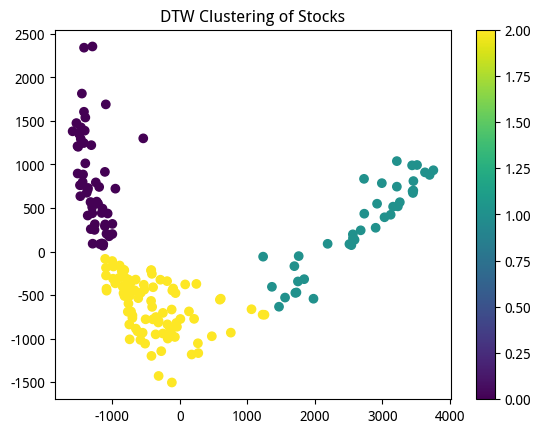

In [13]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

# 使用PCA将高维的DTW距离降到2D
pca = PCA(n_components=2)
dtw_distances_2d = pca.fit_transform(dtw_distances)

# 创建聚类结果的散点图
plt.scatter(dtw_distances_2d[:, 0], dtw_distances_2d[:, 1], c=clusters, cmap='viridis')
plt.colorbar()
plt.title('DTW Clustering of Stocks')
if emo_index == '上证综合情绪值':
    plt.savefig(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_上证综合/DTW_Clustering_of_Stocks3')
if emo_index == '沪深300情绪值':
    plt.savefig(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_沪深300/DTW_Clustering_of_Stocks3')
if emo_index == '创业板情绪值':
    plt.savefig(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_创业板/DTW_Clustering_of_Stocks3')
plt.show()


In [14]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.dates as mdates

# 假设 final_data 已经加载并经过清洗处理
merged_data_cleaned = final_data.copy()

# 将日期列转换为 datetime 类型（确保时间格式正确）
merged_data_cleaned['日期'] = pd.to_datetime(merged_data_cleaned['日期'])

# 设置绘图窗口，一行三列的子图
fig, axes = plt.subplots(3, 1, figsize=(50, 50), subplot_kw={'projection': '3d'})

# 情绪值列名列表
emotion_columns = ['上证综合情绪值', '沪深300情绪值', '创业板情绪值']

# 遍历每个情绪值列
for i, emotion_col in enumerate(emotion_columns):
    ax = axes[i]
    
    # 按股票编号分组
    for stock_code, stock_data in merged_data_cleaned.groupby('股票编号'):
        if stock_code == '000002':  # 如果只关心股票编号为 '000002'
            # 对每个股票编号绘制三维折线图
            x = stock_data[emotion_col]  # 情绪值作为 x 轴
            y = mdates.date2num(stock_data['日期'])  # 时间转换为数值类型，用于 y 轴
            z = stock_data['收益率变化']  # 收益率变化作为 z 轴
            
            # 绘制三维折线图
            ax.plot(x, y, z, label=f"股票 {stock_code}", marker='o', linestyle='-', alpha=0.7)

    # 设置图表标签
    ax.set_xlabel(emotion_col)
    ax.set_ylabel('时间')
    ax.set_zlabel('收益率变化')
    ax.set_title(f'{emotion_col} 与收益率变化的三维关系')

    # 设置 y 轴显示为半年显示一次
    ax.yaxis.set_major_locator(mdates.MonthLocator(bymonthday=15, interval=6))  # 每半年一个刻度
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))  # 按年月显示

    # 自动旋转日期标签，防止重叠
    fig.autofmt_xdate()

# 调整布局
plt.tight_layout()
plt.savefig(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/万科A情绪股价时间序列数据')
# plt.show()
plt.close()

## 数据集成

In [15]:
import pandas as pd

# 读取两个CSV文件
if emo_index == '上证综合情绪值':
    cluster_df = pd.read_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_上证综合/clusters_results.csv', dtype={'股票编号': str})
if emo_index == '沪深300情绪值':
    cluster_df = pd.read_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_沪深300/clusters_results.csv', dtype={'股票编号': str})
if emo_index == '创业板情绪值':
    cluster_df = pd.read_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_创业板/clusters_results.csv', dtype={'股票编号': str})
company_info_df = pd.read_csv(f'{Financial_Data_PATH}/中国公司代码.csv', dtype={'Stkcd': str})  # 假设第二个文件名为company_info.csv

# 重命名列名，统一为 'Stkcd' 以便合并
cluster_df = cluster_df.rename(columns={'股票编号': 'Stkcd'})

# 显式统一合并键的数据类型
cluster_df['Stkcd'] = cluster_df['Stkcd'].astype(str)
company_info_df['Stkcd'] = company_info_df['Stkcd'].astype(str)

# 合并前清除可能重复的列，防止冲突
if 'Stknme' in cluster_df.columns:
    cluster_df = cluster_df.drop(columns=['Stknme'])

# 安全合并
merged_df = pd.merge(cluster_df, company_info_df[['Stkcd', 'Stknme']], on='Stkcd', how='left')

if emo_index == '上证综合情绪值':
    merged_df.to_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_上证综合/clusters_results.csv', index=False)
if emo_index == '沪深300情绪值':
    merged_df.to_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_沪深300/clusters_results.csv', index=False)
if emo_index == '创业板情绪值':
    merged_df.to_csv(f'{ROOT_PATH}/{Clustering_Method}/个股分析/{data_number}/{model}/个股分析_创业板/clusters_results.csv', index=False)

merged_df


,Stkcd,聚类标签,Stknme
0,000002,1,万科A
1,000061,2,农产品
2,000063,0,中兴通讯
3,000069,2,华侨城A
4,000100,0,TCL科技
...,...,...,...
178,603986,0,兆易创新
179,688005,0,容百科技
180,688027,2,国盾量子
181,688029,2,南微医学
